# ΓΙΑΝΝΗΣ ΚΑΡΑΒΕΛΛΑΣ
# 4228

In [24]:
import numpy as np
import cupy as cp
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tqdm import tqdm


Loading the data

In [25]:

# Load the dataset
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()

# Flatten label arrays
y_train_full = y_train_full.flatten()
y_test_full = y_test_full.flatten()


Extracting only 'cat' and 'dog' lables

In [26]:
# Define the classes
class_map = {5: 'dog', 3: 'cat'}

# Filter training data
train_filter = np.isin(y_train_full, list(class_map.keys()))
x_train = x_train_full[train_filter]
y_train = y_train_full[train_filter]

# Filter test data
test_filter = np.isin(y_test_full, list(class_map.keys()))
x_test = x_test_full[test_filter]
y_test = y_test_full[test_filter]

# Map labels to +1 and -1
label_map = {5: 1, 3: -1}
y_train = np.vectorize(label_map.get)(y_train)
y_test = np.vectorize(label_map.get)(y_test)

# Flatten the images
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Normalize pixel values to [0, 1]
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

x_train_mean = cp.mean(x_train, axis=0)
x_train_std = cp.std(x_train, axis=0)
x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std


converting to CuPy arrays

In [28]:
x_train = cp.array(x_train)
y_train = cp.array(y_train)
x_test = cp.array(x_test)
y_test = cp.array(y_test)

# Shuffle the data randomly
indices = cp.arange(x_train.shape[0])
cp.random.shuffle(indices)

# Apply shuffled indices to x_train and y_train
x_train = x_train[indices]
y_train = y_train[indices]




# SVM functions

In [ ]:


def compute_loss(w, X, y, b, reg_lambda):
    dot_products = cp.dot(X, w) + b  
    distances = 1 - y * dot_products
    distances = cp.maximum(0, distances)  # Hinge loss
    hinge_loss = cp.mean(distances)
    reg_loss = 0.5 * reg_lambda * cp.sum(w ** 2)  
    total_loss = hinge_loss + reg_loss
    return total_loss




def compute_gradient(w, X, y, b, reg_lambda):
    n_samples = X.shape[0]
    dot_products = cp.dot(X, w) + b
    distances = 1 - y * dot_products
    misclassified = distances > 0  # Boolean array for misclassified samples
    
    # Gradient for weights
    grad_w = -cp.dot((misclassified * y).T, X) / n_samples + reg_lambda * w
    
    # Gradient for bias
    grad_b = -cp.mean(misclassified * y)  # Mean gradient for bias
    
    return grad_w, grad_b





In [30]:
def up_then_down_scheduler(epoch, total_epochs, ramp_up_epochs, min_lr, max_lr):
    if epoch <= ramp_up_epochs:
        # Linear ramp-up
        lr = min_lr + (max_lr - min_lr) * (epoch / ramp_up_epochs)
    else:
        # Linear ramp-down
        lr = max_lr - (max_lr - min_lr) * ((epoch - ramp_up_epochs) / (total_epochs - ramp_up_epochs))
    return lr


In [31]:
def train_svm(
    X_train, y_train, X_test, y_test,
    min_lr, max_lr, ramp_up_epochs, total_epochs,
    reg_lambda
):
    n_samples, n_features = X_train.shape
    
    # Initialize weights and bias
    w = cp.zeros(n_features)
    b = cp.zeros(1)
    
    train_losses = []
    test_losses = []
    lr_history = []
    
    pbar = tqdm(range(1, total_epochs + 1), desc='Training Progress')
    for epoch in pbar:
        # Determine the current learning rate using the scheduler
        lr = up_then_down_scheduler(epoch, total_epochs, ramp_up_epochs, min_lr, max_lr)
        lr_history.append(lr)
        
        # Compute gradients
        grad_w, grad_b = compute_gradient(w, X_train, y_train, b, reg_lambda)
        
        # Update weights and bias
        w -= lr * grad_w
        b -= lr * grad_b
        
        # Compute losses
        train_loss = compute_loss(w, X_train, y_train, b, reg_lambda)
        test_loss = compute_loss(w, X_test, y_test, b, reg_lambda)
        
        # Store losses (converted to CPU for plotting)
        train_losses.append(cp.asnumpy(train_loss))
        test_losses.append(cp.asnumpy(test_loss))
        
        # Update progress bar description
        pbar.set_description(
            f'Epoch {epoch}, LR: {lr:.5f}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}'
        )
    
    return w, b, train_losses, test_losses, lr_history


# Training section

In [32]:
def predict(X, w, b):
    return cp.sign(cp.dot(X, w) + b)


In [33]:
def run_experiment(min_lr, max_lr, total_epochs, reg_lambda, x_train, y_train, x_test, y_test):
    ramp_up_epochs = total_epochs // 2  # Ramp-up epochs
    results = {'epochs': [], 'accuracy': []}

    # Train the model with current parameters
    w, b, train_losses, test_losses, lr_history = train_svm(
        x_train, y_train, x_test, y_test,
        min_lr=min_lr,
        max_lr=max_lr,
        ramp_up_epochs=ramp_up_epochs,
        total_epochs=total_epochs,
        reg_lambda=reg_lambda
    )

    # Track accuracy across epochs
    for epoch in range(total_epochs):
        predictions = predict(x_test, w, b)
        accuracy = cp.mean(predictions == y_test)  # Calculate accuracy
        results['epochs'].append(epoch + 1)
        results['accuracy'].append(accuracy)

    return results


In [ ]:
# Hyperparameter grid
min_lr_values = [0.0001, 0.0005, 0.001]
max_lr_values = [0.001, 0.005, 0.01]
total_epochs_values = [50, 100, 200,300]

# Static hyperparameter
reg_lambda = 0.001

experiment_results = []

# grid search
for min_lr in min_lr_values:
    for max_lr in max_lr_values:
        for total_epochs in total_epochs_values:
            print(f"Running experiment with min_lr={min_lr}, max_lr={max_lr}, total_epochs={total_epochs}")
            results = run_experiment(
                min_lr=min_lr,
                max_lr=max_lr,
                total_epochs=total_epochs,
                reg_lambda=reg_lambda,
                x_train=x_train,
                y_train=y_train,
                x_test=x_test,
                y_test=y_test
            )
            # Append results with hyperparameters
            experiment_results.append({
                'min_lr': min_lr,
                'max_lr': max_lr,
                'total_epochs': total_epochs,
                'results': results
            })



Running experiment with min_lr=0.0001, max_lr=0.001, total_epochs=50


Epoch 50, LR: 0.00010, Train Loss: 0.8915, Test Loss: 0.8820: 100%|██████████| 50/50 [00:03<00:00, 16.19it/s]


Running experiment with min_lr=0.0001, max_lr=0.001, total_epochs=100


Epoch 100, LR: 0.00010, Train Loss: 0.8773, Test Loss: 0.8700: 100%|██████████| 100/100 [00:06<00:00, 15.56it/s]


Running experiment with min_lr=0.0001, max_lr=0.001, total_epochs=200


Epoch 200, LR: 0.00010, Train Loss: 0.8634, Test Loss: 0.8604: 100%|██████████| 200/200 [00:12<00:00, 16.63it/s]


Running experiment with min_lr=0.0001, max_lr=0.001, total_epochs=300


Epoch 300, LR: 0.00010, Train Loss: 0.8561, Test Loss: 0.8568: 100%|██████████| 300/300 [00:17<00:00, 16.72it/s]


Running experiment with min_lr=0.0001, max_lr=0.005, total_epochs=50


Epoch 50, LR: 0.00010, Train Loss: 0.8606, Test Loss: 0.8587: 100%|██████████| 50/50 [00:03<00:00, 14.69it/s]


Running experiment with min_lr=0.0001, max_lr=0.005, total_epochs=100


Epoch 100, LR: 0.00010, Train Loss: 0.8485, Test Loss: 0.8543: 100%|██████████| 100/100 [00:06<00:00, 16.28it/s]


Running experiment with min_lr=0.0001, max_lr=0.005, total_epochs=200


Epoch 200, LR: 0.00010, Train Loss: 0.8349, Test Loss: 0.8496: 100%|██████████| 200/200 [00:11<00:00, 16.98it/s]


Running experiment with min_lr=0.0001, max_lr=0.005, total_epochs=300


Epoch 300, LR: 0.00010, Train Loss: 0.8256, Test Loss: 0.8460: 100%|██████████| 300/300 [00:17<00:00, 17.01it/s]


Running experiment with min_lr=0.0001, max_lr=0.01, total_epochs=50


Epoch 50, LR: 0.00010, Train Loss: 0.8486, Test Loss: 0.8544: 100%|██████████| 50/50 [00:03<00:00, 16.42it/s]


Running experiment with min_lr=0.0001, max_lr=0.01, total_epochs=100


Epoch 100, LR: 0.00010, Train Loss: 0.8350, Test Loss: 0.8498: 100%|██████████| 100/100 [00:05<00:00, 17.78it/s]


Running experiment with min_lr=0.0001, max_lr=0.01, total_epochs=200


Epoch 200, LR: 0.00010, Train Loss: 0.8187, Test Loss: 0.8431: 100%|██████████| 200/200 [00:11<00:00, 17.78it/s]


Running experiment with min_lr=0.0001, max_lr=0.01, total_epochs=300


Epoch 300, LR: 0.00010, Train Loss: 0.8080, Test Loss: 0.8405: 100%|██████████| 300/300 [00:17<00:00, 17.16it/s]


Running experiment with min_lr=0.0005, max_lr=0.001, total_epochs=50


Epoch 50, LR: 0.00050, Train Loss: 0.8854, Test Loss: 0.8765: 100%|██████████| 50/50 [00:03<00:00, 16.40it/s]


Running experiment with min_lr=0.0005, max_lr=0.001, total_epochs=100


Epoch 100, LR: 0.00050, Train Loss: 0.8708, Test Loss: 0.8653: 100%|██████████| 100/100 [00:05<00:00, 17.77it/s]


Running experiment with min_lr=0.0005, max_lr=0.001, total_epochs=200


Epoch 200, LR: 0.00050, Train Loss: 0.8577, Test Loss: 0.8575: 100%|██████████| 200/200 [00:11<00:00, 17.78it/s]


Running experiment with min_lr=0.0005, max_lr=0.001, total_epochs=300


Epoch 300, LR: 0.00050, Train Loss: 0.8508, Test Loss: 0.8549: 100%|██████████| 300/300 [00:17<00:00, 16.68it/s]


Running experiment with min_lr=0.0005, max_lr=0.005, total_epochs=50


Epoch 50, LR: 0.00050, Train Loss: 0.8592, Test Loss: 0.8581: 100%|██████████| 50/50 [00:03<00:00, 15.28it/s]


Running experiment with min_lr=0.0005, max_lr=0.005, total_epochs=100


Epoch 100, LR: 0.00050, Train Loss: 0.8471, Test Loss: 0.8540: 100%|██████████| 100/100 [00:06<00:00, 16.31it/s]


Running experiment with min_lr=0.0005, max_lr=0.005, total_epochs=200


Epoch 200, LR: 0.00050, Train Loss: 0.8332, Test Loss: 0.8489: 100%|██████████| 200/200 [00:11<00:00, 16.83it/s]


Running experiment with min_lr=0.0005, max_lr=0.005, total_epochs=300


Epoch 300, LR: 0.00050, Train Loss: 0.8237, Test Loss: 0.8452: 100%|██████████| 300/300 [00:17<00:00, 17.65it/s]


Running experiment with min_lr=0.0005, max_lr=0.01, total_epochs=50


Epoch 50, LR: 0.00050, Train Loss: 0.8479, Test Loss: 0.8542: 100%|██████████| 50/50 [00:03<00:00, 16.26it/s]


Running experiment with min_lr=0.0005, max_lr=0.01, total_epochs=100


Epoch 100, LR: 0.00050, Train Loss: 0.8342, Test Loss: 0.8494: 100%|██████████| 100/100 [00:05<00:00, 17.69it/s]


Running experiment with min_lr=0.0005, max_lr=0.01, total_epochs=200


Epoch 200, LR: 0.00050, Train Loss: 0.8177, Test Loss: 0.8427: 100%|██████████| 200/200 [00:11<00:00, 17.68it/s]


Running experiment with min_lr=0.0005, max_lr=0.01, total_epochs=300


Epoch 300, LR: 0.00050, Train Loss: 0.8070, Test Loss: 0.8403: 100%|██████████| 300/300 [00:17<00:00, 17.64it/s]


Running experiment with min_lr=0.001, max_lr=0.001, total_epochs=50


Epoch 50, LR: 0.00100, Train Loss: 0.8793, Test Loss: 0.8715: 100%|██████████| 50/50 [00:03<00:00, 16.30it/s]


Running experiment with min_lr=0.001, max_lr=0.001, total_epochs=100


Epoch 100, LR: 0.00100, Train Loss: 0.8652, Test Loss: 0.8616: 100%|██████████| 100/100 [00:05<00:00, 17.70it/s]


Running experiment with min_lr=0.001, max_lr=0.001, total_epochs=200


Epoch 200, LR: 0.00100, Train Loss: 0.8528, Test Loss: 0.8556: 100%|██████████| 200/200 [00:11<00:00, 17.70it/s]


Running experiment with min_lr=0.001, max_lr=0.001, total_epochs=300


Epoch 300, LR: 0.00100, Train Loss: 0.8455, Test Loss: 0.8535: 100%|██████████| 300/300 [00:17<00:00, 17.42it/s]


Running experiment with min_lr=0.001, max_lr=0.005, total_epochs=50


Epoch 50, LR: 0.00100, Train Loss: 0.8577, Test Loss: 0.8575: 100%|██████████| 50/50 [00:03<00:00, 14.86it/s]


Running experiment with min_lr=0.001, max_lr=0.005, total_epochs=100


Epoch 100, LR: 0.00100, Train Loss: 0.8454, Test Loss: 0.8536: 100%|██████████| 100/100 [00:06<00:00, 14.34it/s]


Running experiment with min_lr=0.001, max_lr=0.005, total_epochs=200


Epoch 200, LR: 0.00100, Train Loss: 0.8313, Test Loss: 0.8482: 100%|██████████| 200/200 [00:12<00:00, 16.06it/s]


Running experiment with min_lr=0.001, max_lr=0.005, total_epochs=300


Epoch 300, LR: 0.00100, Train Loss: 0.8215, Test Loss: 0.8443: 100%|██████████| 300/300 [00:18<00:00, 16.57it/s]


Running experiment with min_lr=0.001, max_lr=0.01, total_epochs=50


Epoch 50, LR: 0.00100, Train Loss: 0.8470, Test Loss: 0.8541: 100%|██████████| 50/50 [00:03<00:00, 15.27it/s]


Running experiment with min_lr=0.001, max_lr=0.01, total_epochs=100


Epoch 100, LR: 0.00100, Train Loss: 0.8332, Test Loss: 0.8490: 100%|██████████| 100/100 [00:06<00:00, 16.62it/s]


Running experiment with min_lr=0.001, max_lr=0.01, total_epochs=200


Epoch 200, LR: 0.00100, Train Loss: 0.8164, Test Loss: 0.8422: 100%|██████████| 200/200 [00:11<00:00, 16.80it/s]


Running experiment with min_lr=0.001, max_lr=0.01, total_epochs=300


Epoch 300, LR: 0.00100, Train Loss: 0.8057, Test Loss: 0.8402: 100%|██████████| 300/300 [00:18<00:00, 16.27it/s]


# Predictions, evaluations and plots

 Accuracy Over Epochs for Each Learning Rate Pair

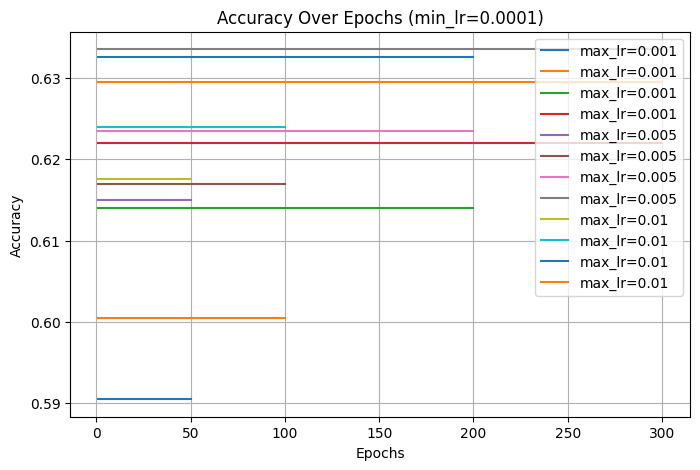

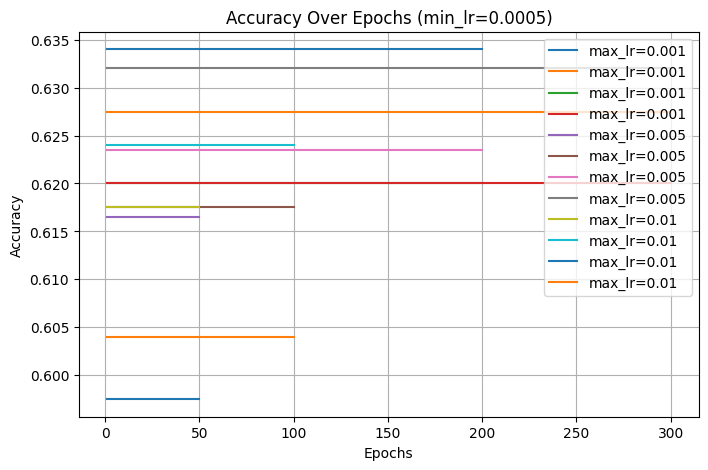

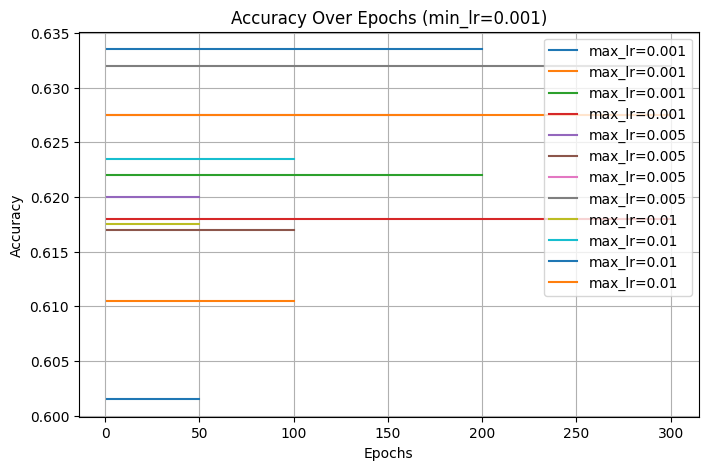

In [ ]:
for min_lr in min_lr_values:
    plt.figure(figsize=(8, 5)) 
    for exp in experiment_results:
        if exp['min_lr'] == min_lr:
            max_lr = exp['max_lr']
            results = exp['results']
            epochs = cp.asnumpy(cp.array(results['epochs']))
            accuracies = cp.asnumpy(cp.array(results['accuracy']))
            plt.plot(epochs, accuracies, label=f"max_lr={max_lr}")

    plt.title(f"Accuracy Over Epochs (min_lr={min_lr})")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='upper right')  
    plt.grid(True)  
    plt.show()
